## FineTuning CAMeLBERT for Multi-Class Classification with Mawqif dataset.

In [ ]:
!python --version

Python 3.11.12


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!pip install transformers datasets

In [ ]:
#!pip install transformers[torch] accelerate -U

In [ ]:
import torch, os
import pandas as pd
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from torch.utils.data import Dataset

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
ROOT_DIR = '/content/drive/MyDrive/Datasets/Stance_Detection_CAMelBERT/'

## Data Exploration and Preprocessing

In [ ]:
df= pd.read_csv(ROOT_DIR + "Mawqif.csv", keep_default_na=False)

In [ ]:
df.head()

,ID,text,target,stance,sarcasm,sentiment
0,1,عشان يلمع صورته ويعنني تمكين المرأة ويصير ترن...,Women empowerment,Against,No,Negative
1,3,روح حلل محد يم تطعيم كورونا شف الحرم البارح م...,Covid Vaccine,None,Yes,Neutral
2,4,هذا ما يُعرّف بـ'فوبيا المرأة المُتمكنة' آفة ف...,Women empowerment,Favor,Yes,Negative
3,6,#LEAP22 مؤتمر يجمع اشهر وابرز المؤثرين في الم...,Digital Transformation,Favor,No,Positive
4,7,خصوصية البيانات وحمايتها في المنظمة مطلب ولكن ...,Digital Transformation,Favor,No,Neutral


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3502 entries, 0 to 3501
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3502 non-null   int64 
 1   text       3502 non-null   object
 2   target     3502 non-null   object
 3   stance     3502 non-null   object
 4   sarcasm    3502 non-null   object
 5   sentiment  3502 non-null   object
dtypes: int64(1), object(5)
memory usage: 164.3+ KB


In [ ]:
df_org = df[['text', 'stance']]
df_org.head()

,text,stance
0,عشان يلمع صورته ويعنني تمكين المرأة ويصير ترن...,Against
1,روح حلل محد يم تطعيم كورونا شف الحرم البارح م...,None
2,هذا ما يُعرّف بـ'فوبيا المرأة المُتمكنة' آفة ف...,Favor
3,#LEAP22 مؤتمر يجمع اشهر وابرز المؤثرين في الم...,Favor
4,خصوصية البيانات وحمايتها في المنظمة مطلب ولكن ...,Favor


In [ ]:
labels = df_org['stance'].unique().tolist()
labels

['Against', 'None', 'Favor']

In [ ]:
for key, value in enumerate(labels):
  print(key , value)

0 Against
1 None
2 Favor


In [ ]:
NUM_LABELS = len(labels)

# Creating labels for the stance, to use them in training and evaluating

id2label = {id:label for id,label in enumerate(labels)}

label2id = {label:id for id,label in enumerate(labels)}

In [ ]:
print(label2id, id2label)

{'Against': 0, 'None': 1, 'Favor': 2} {0: 'Against', 1: 'None', 2: 'Favor'}


In [ ]:
df_org["labels"]= pd.factorize(df_org.stance)[0]

<ipython-input-61-dd7622f77169>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_org["labels"]= pd.factorize(df_org.stance)[0]


In [ ]:
df_org.tail(10)

,text,stance,labels
3492,في ظل رؤية 2030 و صناعة السياحه انتظرت اليوم ...,Favor,2
3493,تحديات للتحول الرقمي في الموارد البشرية ... #...,None,1
3494,تمكين المرأة يعني فتح المجال لها للعمل في مجال...,Favor,2
3495,وحده من الحسنات القليله في كورونا هو لجوء الكث...,Favor,2
3496,التحول من النظام الورقي الى النظام الرقمى يعنى...,Favor,2
3497,يا جماعة الخير انا و اهلي حاشتنا كورونا خلصنا ...,None,1
3498,للاسف بعض مدراء الدوائر من العقليات القديمة س...,Favor,2
3499,ليس عصر تمكين المرأة . وإنما عصر تدمير الأسرة...,Against,0
3500,ياجماعه الخير هل يعقل اليوم جهة خدمية تذهب لا...,Favor,2
3501,التحول الالكتروني يقضي على هذه الفوضى ويرتقي ...,Favor,2


<Axes: ylabel='count'>

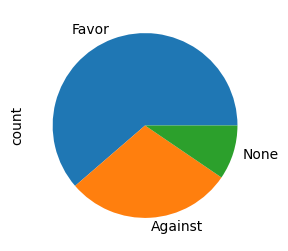

In [ ]:
df['stance'].value_counts().plot(kind='pie', figsize=(3,3))

# Building The Model.
We will use CAMeLBERT to fine-tune it for the task of stance detection

In [ ]:
model_name = "CAMeL-Lab/bert-base-arabic-camelbert-mix"
model_name

'CAMeL-Lab/bert-base-arabic-camelbert-mix'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-mix and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Train test split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
#Spliting the original dataframe into train and test --> 85-15
train_df, test_df = train_test_split(df_org, test_size=0.15, random_state=42)

# Spliting the train data frame into train and evaluat --> 85-15
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=42)


print(f'Training set: {len(train_df)}')
print(f'Validation set: {len(val_df)}')
print(f'Test set: {len(test_df)}')

Training set: 2529
Validation set: 447
Test set: 526


In [ ]:
# Saving into files
train_df.to_csv(ROOT_DIR+"/S8515"+'/train_df.csv', index=False)
val_df.to_csv(ROOT_DIR+"/S8515"+'/val_df.csv', index=False)
test_df.to_csv(ROOT_DIR+"/S8515"+'/test_df.csv', index=False)

In [ ]:
# Reading the data from saved files
train_df = pd.read_csv(ROOT_DIR+"/S8515"+'/train_df.csv', keep_default_na=False)
test_df = pd.read_csv(ROOT_DIR+"/S8515"+'/test_df.csv', keep_default_na=False)
val_df = pd.read_csv(ROOT_DIR+"/S8515"+'/val_df.csv', keep_default_na=False)

In [ ]:
X_train = list(train_df.text)
y_train = list(train_df.labels)

X_test = list(test_df.text)
y_test = list(test_df.labels)

X_val = list(val_df.text)
y_val = list(val_df.labels)

In [ ]:
len(X_train), len(X_test) ,len(X_val)#3502

(2529, 526, 447)

In [ ]:
train_encodings = tokenizer(X_train, truncation=True, padding=True)
val_encodings  = tokenizer(X_val, truncation=True, padding=True) #val_texts_new
test_encodings = tokenizer(X_test, truncation=True, padding=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
class DataLoader(Dataset):

    def __init__(self, encodings, labels):

        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):

        # Retrieve tokenized data for the given index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add the label for the given index to the item dictionary
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):

        return len(self.labels)

In [ ]:
train_dataloader = DataLoader(train_encodings, y_train)#train_labels

val_dataloader = DataLoader(val_encodings, y_val) #val_labels

test_dataset = DataLoader(test_encodings, y_test)

## Training with Trainer Class

In [ ]:
from transformers import TrainingArguments, Trainer

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):

    # Extract true labels from the input object
    labels = pred.label_ids

    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)

    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=1)

    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }


In [ ]:
model_path = 'stanceEval-8515'

In [ ]:
##OH: To change
"""
do_eval=True/False
evaluation_strategy=steps/epoch
"""
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    # output_dir='./stanceEval-8515',
    do_train=True,
    do_eval=True,
    #  The number of epochs, defaults to 3.0
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy='steps',
    logging_dir='./multi-class-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    fp16=True, ## with GPUs only
    learning_rate=3e-5,
    load_best_model_at_end=True
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(
    # the pre-trained model that will be fine-tuned
    model=model,
     # training arguments that we defined above
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=val_dataloader,
    compute_metrics= compute_metrics
)

In [ ]:
import wandb
wandb.init(mode="disabled")


In [ ]:
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=240, training_loss=0.5710853695869446, metrics={'train_runtime': 52.1183, 'train_samples_per_second': 145.573, 'train_steps_per_second': 4.605, 'total_flos': 393789827208078.0, 'train_loss': 0.5710853695869446, 'epoch': 3.0})

In [ ]:
q=[trainer.evaluate(eval_dataset=df_org) for df_org in [train_dataloader, val_dataloader, test_dataset]]

In [ ]:
pd.DataFrame(q, index=["train","val","test"]).iloc[:,:5]

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.201281,0.939502,0.890517,0.934549,0.865834
val,0.590929,0.765101,0.618988,0.661849,0.618626
test,0.585070,0.781369,0.672178,0.760323,0.651302


In [ ]:
model_path

'stanceEval-8515'

In [ ]:
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('stanceEval-8515/tokenizer_config.json',
 'stanceEval-8515/special_tokens_map.json',
 'stanceEval-8515/vocab.txt',
 'stanceEval-8515/added_tokens.json',
 'stanceEval-8515/tokenizer.json')

In [ ]:
from transformers import pipeline
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer= AutoTokenizer.from_pretrained(model_path)


nlp = pipeline("text-classification", model=model, tokenizer=tokenizer)

Device set to use cuda:0


In [ ]:
predicted_labels = []

# Apply the model to each text
for text in X_test:
    # Apply the model to the text
    result = nlp(text)

    # Extract the predicted label
    predicted_label = result[0]['label']

    # Append the predicted label to the list
    predicted_labels.append(predicted_label)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
mapping = {0: 'Against', 1: 'None', 2: 'Favor'}

In [ ]:
gold_labels = [mapping[val] for val in y_test]

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(gold_labels, predicted_labels)

# Calculate precision
precision = precision_score(gold_labels, predicted_labels, average='weighted')

# Calculate recall
recall = recall_score(gold_labels, predicted_labels, average='weighted')

# Calculate F1-score
f1 = f1_score(gold_labels, predicted_labels, average='weighted')

# Calculate confusion matrix
conf_matrix = confusion_matrix(gold_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.7813688212927756
Precision: 0.7847015370105651
Recall: 0.7813688212927756
F1-score: 0.7721703001303053
Confusion Matrix:
[[123  32   0]
 [ 42 272   5]
 [ 16  20  16]]
